In [1]:
!pip install scikit-survival

     |████████████████████████████████| 2.5 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.17.1-cp37-cp37m-linux_x86_64.whl size=4088280 sha256=243afd36e01c75425e2aefe2642affbfd8a165e986c850c829b33661777a1abb
  Stored in directory: /root/.cache/pip/wheels/78/43/46/b5c9ba2d44e7e5de3d321c76bbff4e5480cd69d486b38d359f
Successfully built scikit-survival


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from datetime import datetime
import time
from scipy import stats
from scipy.stats import norm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import warnings
import sksurv
from sksurv.metrics import(
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    as_cumulative_dynamic_auc_scorer,
    as_concordance_index_ipcw_scorer,
    as_integrated_brier_score_scorer,
)
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("/content/drive/MyDrive/survival_dataset_with_apd.csv", header='infer', sep=',')
data = data.drop(['Unnamed: 0', 'year', 'month', 'date', 'weekday', 'hour', 'minute'], axis=1)
data['timeStamp'] = pd.to_datetime(data['timeStamp'], format='%Y-%m-%d %H:%M:%S')
data['departDate'] = pd.to_datetime(data['departDate'], format='%Y-%m-%d')
data = data.sort_values(by=['timeStamp'])

In [ ]:
complete_dataset = pd.DataFrame()
data = data[data.advPurchaseDays < 30]

for item in list(set(data.advPurchaseDays)):
    df = data[data.advPurchaseDays == item]
    df = df.sort_values(by=['timeStamp'])
    df['pricediff'] = df['totalFare'].diff(1)
    df['timediff'] = df['timeStamp'].diff(1)
    df['timediff'] = df['timediff'].dt.seconds/60
    df = df.iloc[1:]
    df['change'] = np.where(df['pricediff'] != 0, True, False)
    idx=list(df.columns).index('timeStamp')
    idy=list(df.columns).index('totalFare')
    
    final = []
    tempvar = 0
    prevflag = True
    for i in range(len(df)):
        if df.iloc[i, 7] == True:
            tempvar = tempvar + df.iloc[i, 6] if prevflag == False else df.iloc[i, 6]
            final.append(tempvar)
            prevflag=True
        else:
            tempvar = tempvar + df.iloc[i, 6]
            final.append(tempvar)
            prevflag=False
            
    df = df.reset_index(drop=True)
    last = pd.concat([df, pd.Series(final)], axis=1)
    last.columns = ['timeStamp', 'departDate', 'totalFare', 'sector', 'advPurchaseDays', 'pricediff', 'timediff', 'change', 'survival_mins']
    last['year'] = pd.DatetimeIndex(last['timeStamp']).year
    last['month'] = pd.DatetimeIndex(last['timeStamp']).month
    last['date'] = pd.DatetimeIndex(last['timeStamp']).day
    last['weekday'] = pd.DatetimeIndex(last['timeStamp']).weekday
    last['hour'] = pd.DatetimeIndex(last['timeStamp']).hour
    last['minute'] = pd.DatetimeIndex(last['timeStamp']).minute
    last = last[(last.survival_mins > 0)]
    
    complete_dataset = pd.concat([complete_dataset, last], axis=0)
    print(item)

In [ ]:
complete_dataset

,timeStamp,departDate,totalFare,sector,advPurchaseDays,pricediff,timediff,change,survival_mins,year,month,date,weekday,hour,minute
0,2022-01-19 00:29:41,2022-01-20,7424,DEL-GOI,0,0.0,27.800000,False,27.800000,2022,1,19,2,0,29
1,2022-01-19 01:02:34,2022-01-20,7424,DEL-GOI,0,0.0,32.883333,False,60.683333,2022,1,19,2,1,2
2,2022-01-19 01:30:18,2022-01-20,14319,DEL-GOI,0,6895.0,27.733333,True,88.416667,2022,1,19,2,1,30
3,2022-01-19 02:32:44,2022-01-20,14319,DEL-GOI,0,0.0,62.433333,False,150.850000,2022,1,19,2,2,32
4,2022-01-19 02:48:43,2022-01-20,7424,DEL-GOI,0,-6895.0,15.983333,True,166.833333,2022,1,19,2,2,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,2022-02-08 20:31:57,2022-02-08,17368,DEL-GOI,-1,9944.0,31.850000,True,31.850000,2022,2,8,1,20,31
1417,2022-02-08 20:46:40,2022-02-08,7424,DEL-GOI,-1,-9944.0,14.716667,True,14.716667,2022,2,8,1,20,46
1418,2022-02-08 21:01:01,2022-02-08,7424,DEL-GOI,-1,0.0,14.350000,False,29.066667,2022,2,8,1,21,1
1419,2022-02-08 21:22:23,2022-02-08,7424,DEL-GOI,-1,0.0,21.366667,False,50.433333,2022,2,8,1,21,22


In [ ]:
complete_dataset['advPurchaseDays'].value_counts()

In [6]:
df = complete_dataset[(complete_dataset.timediff > 0)]
df = df.loc[df['advPurchaseDays'] > 20]
idx = df.columns.isin(['totalFare', 'advPurchaseDays', 'year', 'month', 'date', 'weekday', 'hour', 'minute'])
X_train = df.iloc[:-900, idx]
idy = df.columns.isin(['change', 'timediff'])
y_train = df.iloc[:-900, idy]
aux = [(e2,e1) for e1,e2 in y_train.to_numpy()]
y_train = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
X_test = df.iloc[-900:, idx]
y_test = df.iloc[-900:, idy]
aux = [(e2,e1) for e1,e2 in y_test.to_numpy()]
y_test = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11315, 8) (11315,) (900, 8) (900,)


In [7]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=41)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=12,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(X_train, y_train)

(8486, 8) (8486,) (2829, 8) (2829,)


RandomSurvivalForest(max_features='sqrt', min_samples_leaf=12,
                     min_samples_split=8, n_jobs=-1, random_state=20)

Concordance Index

In [ ]:
rsf.score(X_test, y_test)

0.6704295644641909

In [ ]:
print(concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], cph_risk_scores))
print(concordance_index_ipcw(y_train, y_test, cph_risk_scores))

(0.6704295644641909, 1998485, 982417, 1, 961)
(0.6662956698739918, 1998485, 982417, 1, 961)


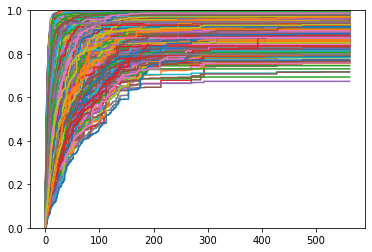

In [ ]:
survs = rsf.predict_survival_function(X_test)
for i in range(len(survs)):
  survs[i].y = 1-survs[i].y
threshold = 0.6
for fn in survs:
   plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

In [ ]:
def inv(y, survs, j) : 
  lo = 0 
  hi = survs[j].x[-1]
  while(lo < hi) : 
    mid = (lo+hi)/2
    val = survs[0](mid) 
    if abs(val-y) <= 1e-4 : 
      return mid 
    elif val < y : 
      lo = mid + 1 
    else :
      hi = mid - 1 
  return lo 

In [ ]:
error = []
from sklearn.metrics import mean_absolute_error
y_true = y_test['Survival_in_days']

intervals = np.arange(0, 1, 0.05)
for interval in intervals:
  y_pred = []
  for i in range(len(survs)):
    y_pred.append(inv(interval, survs, i))
  error.append(mean_absolute_error(y_true, y_pred))

In [ ]:
import plotly.express as px
fig = px.line(x=intervals , y=error)
fig.update_layout(
    width = 600,
    xaxis_title='Threshold',
    yaxis_title='Mean Absolute Error (minutes)'
)
fig.show()

Integrated Brier Score for RSF

In [ ]:
survs = rsf.predict_survival_function(X_test)
times = np.arange(2, 400)
preds = np.asarray([[1-fn(t) for t in times] for fn in survs])

from sksurv.metrics import integrated_brier_score
score = integrated_brier_score(y_test, y_test, preds, times)
print(score)

0.8234583934594882


Cumulative Dynamic AUC for RSF

In [ ]:

va_times = np.arange(8, 340, 7)
cph_risk_scores = rsf.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, cph_risk_scores, va_times
)

fig = px.line(x=va_times, y=cph_auc, markers=True)
fig.add_hline(cph_mean_auc)
fig.show()

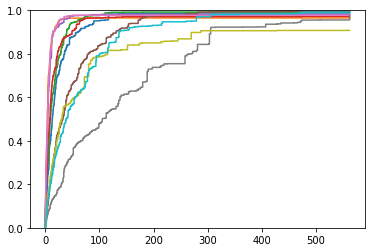

In [ ]:
chf_funcs = rsf.predict_survival_function(X_test[:10])

for fn in chf_funcs:
   plt.step(fn.x, 1-fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

In [ ]:
from sksurv.metrics import as_integrated_brier_score_scorer
asbs = as_integrated_brier_score_scorer(rsf, times)
asbs.fit(X_train, y_train)

In [ ]:
asbs.score(X_test, y_test)

-0.04438544711740865

Model Integrated Metrics (Random Survival Forest)
1. Brier Score
2. Cumulative/Dynamic AUC
3. Concordance Index IPCW

In [ ]:
asbs = as_integrated_brier_score_scorer(rsf, times)
asas = as_cumulative_dynamic_auc_scorer(rsf, times)
asis = as_concordance_index_ipcw_scorer(rsf)

asbs.fit(X_train, y_train)
asas.fit(X_train, y_train)
asis.fit(X_train, y_train)

print('asbs', asbs.score(X_test, y_test))
print('asas', asas.score(X_test, y_test))
print('asis', asis.score(X_test, y_test))

asbs -0.04438544711740865
asas 0.7582115993783259
asis 0.6662956698739918


In [ ]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)

est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.545


In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

In [ ]:
cox_elastic_net.score(X_test, y_test)

0.5997628516180816

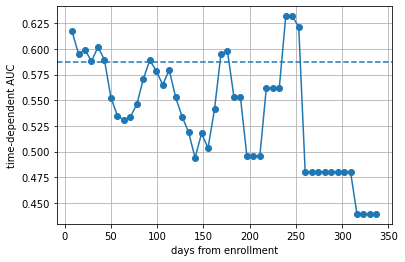

In [ ]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
va_times = np.arange(8, 340, 7)
cph_risk_scores = cox_elastic_net.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, cph_risk_scores, va_times
)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)


In [ ]:
X_train.dtype

In [ ]:
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

estimator.fit(X_train, y_train)